LeNet5 model 

In [68]:
import pandas as pd 
import numpy as np 



import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    torch.cuda.empty_cache()

In [3]:
# defining hyperparameters 
epochs = 40   #the nn will train 40 times over all 50.000 images and validate itself with 12.000 images x 40 times) 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 32 
classes = 43 
img_size = 32
random_seed = 42

In [4]:
def get_accuracy(model, data_loader, device):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [5]:
def plot_losses(train_losses, valid_losses):

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [6]:
# train function

def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [7]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [8]:
# training function

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [9]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.3403, 0.3121, 0.3214),
                                    (0.2724, 0.2608, 0.2669))

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      ])
   
    train_transform = transforms.Compose([transforms.Resize((32,32)),
                                       transforms.ToTensor(),
                                       normalize])

    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=train_transform,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7fd268221340>, <torch.utils.data.dataloader.DataLoader object at 0x7fd1b88c0a30>)


In [10]:
# model function 
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [11]:
for x, y in valid_loader:
    print(x)

tensor([[[[-1.0189e+00, -1.0045e+00, -9.9013e-01,  ..., -9.6134e-01,
           -9.6134e-01, -9.9013e-01],
          [-9.9013e-01, -9.9013e-01, -9.9013e-01,  ..., -9.4694e-01,
           -9.6134e-01, -9.7573e-01],
          [-1.0045e+00, -9.7573e-01, -9.9013e-01,  ..., -9.3255e-01,
           -9.4694e-01, -9.9013e-01],
          ...,
          [-1.0045e+00, -1.0333e+00, -1.0333e+00,  ..., -1.0621e+00,
           -1.0765e+00, -1.0909e+00],
          [-1.0045e+00, -1.0477e+00, -1.0477e+00,  ..., -1.0621e+00,
           -1.0765e+00, -1.1053e+00],
          [-1.0333e+00, -1.0477e+00, -1.0477e+00,  ..., -1.0765e+00,
           -1.0765e+00, -1.1053e+00]],

         [[-9.4108e-01, -9.5612e-01, -9.4108e-01,  ..., -9.4108e-01,
           -9.4108e-01, -9.5612e-01],
          [-9.2604e-01, -9.4108e-01, -9.4108e-01,  ..., -9.2604e-01,
           -9.4108e-01, -9.5612e-01],
          [-9.4108e-01, -9.2604e-01, -9.4108e-01,  ..., -9.1101e-01,
           -9.2604e-01, -9.7115e-01],
          ...,
     

In [12]:

torch.manual_seed(random_seed)

model = LeNet5(classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

20:14:43 --- Epoch: 0	Train loss: 3.3910	Valid loss: 3.0015	Train accuracy: 23.59	Valid accuracy: 23.25
20:14:50 --- Epoch: 1	Train loss: 2.5828	Valid loss: 2.2323	Train accuracy: 40.09	Valid accuracy: 39.25
20:14:58 --- Epoch: 2	Train loss: 1.9608	Valid loss: 1.7528	Train accuracy: 52.41	Valid accuracy: 51.45
20:15:05 --- Epoch: 3	Train loss: 1.5399	Valid loss: 1.3881	Train accuracy: 64.02	Valid accuracy: 62.50
20:15:12 --- Epoch: 4	Train loss: 1.2219	Valid loss: 1.1196	Train accuracy: 72.42	Valid accuracy: 71.36
20:15:19 --- Epoch: 5	Train loss: 0.9910	Valid loss: 0.9235	Train accuracy: 78.82	Valid accuracy: 77.33
20:15:27 --- Epoch: 6	Train loss: 0.8202	Valid loss: 0.7752	Train accuracy: 83.04	Valid accuracy: 81.34
20:15:34 --- Epoch: 7	Train loss: 0.6900	Valid loss: 0.6603	Train accuracy: 86.06	Valid accuracy: 84.95
20:15:41 --- Epoch: 8	Train loss: 0.5889	Valid loss: 0.5700	Train accuracy: 88.31	Valid accuracy: 87.20
20:15:49 --- Epoch: 9	Train loss: 0.5092	Valid loss: 0.4983	Trai

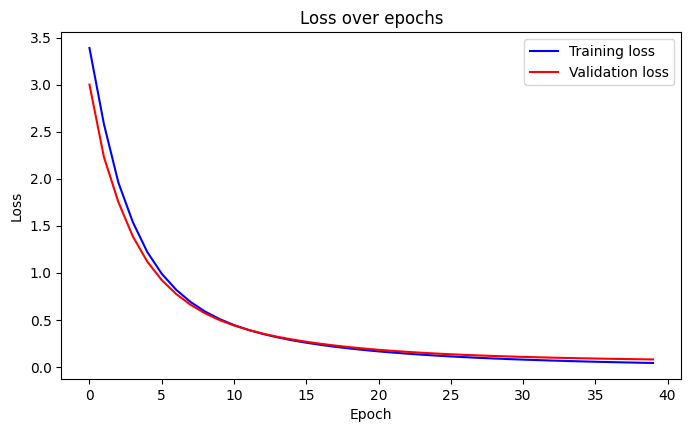

In [13]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

# Find adversarial samples with ART.

In [69]:
# We have a trained model from the code above
# Put everything on CPU
model.to('cpu')

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=43, bias=True)
  )
)

### Find a single adversarial example

In [70]:
# loading dataset 
transforms = transforms.Compose([transforms.Resize((32, 32)),
    transforms.ToTensor()])
    
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [67]:
x, y_true = test_dataset[0]
x.shape, x.min(), x.max()

(torch.Size([3, 32, 32]), tensor(0.0392), tensor(0.7176))

What does X look like?

If we want to correctly display X, we need to first reverse the normalization transform defined above.

In [71]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [72]:
inverse_normalize = NormalizeInverse(mean=(0.3403, 0.3121, 0.3214), std=(0.2724, 0.2608, 0.2669))  # Same mean and std values as defined in the original transforms.

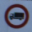

In [73]:
import torchvision
torchvision.transforms.ToPILImage()(x)

We will be looking for adversarial examples on the original inputs, not the normalized inputs. The original inputs (the ones that have not been normalized yet) have values between [0, 1]. The adversarial samples should also have values in the same range.

However, our model expects inputs that are normalized.

We therefore write a small wrapper around our model that accepts unnormalized inputs, but does the normalization before passing it to the original model. This allows ART to search for adversarial samples in the original [0,1] range.

In [74]:
class WrappedModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.trained_model = model  # "model" is our trained model
    self.trained_model.to("cpu")
    self.normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))

  def forward(self, x: torch.Tensor):
    # x comes in as a Tensor of shape [3, 32, 32]
    # Manually add a batch dimension
    x = torch.unsqueeze(x, dim=0)
    # Shape of x is now [1, 3, 32, 32]
    # Normalize the input
    x_normalized = self.normalize(x)
    # Return only the logits
    logits, _ = self.trained_model(x_normalized)
    return logits

In [75]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

In [76]:
# We again wrap our (already wrapped) model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
      model=WrappedModel(),
      clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
      loss=criterion,  # defined above
      optimizer=optimizer,  # defined above
      input_shape=(3, 32, 32),
      nb_classes=43,
      device_type="cpu"
)

In [77]:
x.device

device(type='cpu')

FGSM attack 

In [78]:
# Define an ART attack and create a generator 
attack = FastGradientMethod(estimator=classifier, eps=0.1)
#x_test_adv = attack.generate(x_test.numpy())

#predictions = classifier.predict(x_test_adv)
#predictions = torch.from_numpy(predictions)


In [79]:
#x_test_adv.shape

In [80]:
# Find an adversarial sample
# ART expects inputs to be numpy arrays!

# Find adversarial samples in the original input domain - which is unnormalized
benign_x = inverse_normalize(x)
benign_x = benign_x.cpu().numpy()
type(benign_x), benign_x.min(), benign_x.max()

(numpy.ndarray, 0.3284639, 0.51294005)

In [81]:
x_adversarial = attack.generate(benign_x)    # lijst van maken

In [82]:
x_adversarial.shape

(3, 32, 32)

In [83]:
x_adversarial.min(), x_adversarial.max()

(0.23050943, 0.6118934)

### Check the predictions

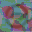

In [84]:
torchvision.transforms.ToPILImage()(torch.Tensor(x_adversarial))

In [85]:
test_model = WrappedModel()


In [86]:
torch.argmax(test_model(torch.Tensor(x_adversarial)))

tensor(13)

In [87]:
y

tensor([12, 12, 31, 10,  5, 41, 18, 38,  2,  7, 18,  5,  7,  2, 11, 35])

In [ ]:
from os import listdir
import os 

In [ ]:
#def get_accuracy_adv(data_loader):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to('cpu')
            y_true = y_true.to('cpu')

            classifier = PyTorchClassifier(
            model=WrappedModel(),
            clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
            loss=criterion,  # defined above
            optimizer=optimizer,  # defined above
            input_shape=(3, 32, 32),
            nb_classes=43,
            device_type="cpu"
            )
            attack = FastGradientMethod(estimator=classifier, eps=0.1)
            x_test_adv = X.cpu().numpy()
            x_adversarial = attack.generate(x_test_adv)
            test_model = WrappedModel()

            _, y_prob = test_model(X)
            _, predicted_labels = torch.argmax(test_model(torch.Tensor(x_adversarial, 1)))
            
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [ ]:
#get_accuracy_adv(test_loader)

In [ ]:
#def generate_attack(dataloader):
  open('/volumes1/thesis/notebooks/data/gtsrb/GTSRB/adversarial_samples')
  
  true_labels = []


  for X, y_true in dataloader:
    X = x.to('cpu')
    y_true = y_true.to('çpu')

  
    classifier = PyTorchClassifier(
      model=WrappedModel(),
      clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
      loss=criterion,  # defined above
      optimizer=optimizer,  # defined above
      input_shape=(3, 32, 32),
      nb_classes=43,
      device_type="cpu"
    )
    # Define an ART attack and create a generator 
    attack = FastGradientMethod(estimator=classifier, eps=0.1)

    # Find an adversarial sample
    # ART expects inputs to be numpy arrays!

    # Find adversarial samples in the original input domain - which is unnormalize
    benign_x = x.cpu().numpy()  # convert torch to numpy
    #type(benign_x), benign_x.min(), benign_x.max()
    x_adversarial = attack.generate(benign_x) 
    torchvision.transforms.ToPILImage()(torch.Tensor(x_adversarial))
    #attacks.append(adversarial_sample)
    test_model = WrappedModel()
    prediction = torch.argmax(test_model(torch.Tensor(x_adversarial)))
    
    accuracy = get_accuracy_adv()


    close('/volumes1/thesis/notebooks/data/gtsrb/GTSRB/adversarial_samples')
    return prediction, y, correct_pred, accuracy, true_labels



In [ ]:
#generate_attack(test_dataset)

In [ ]:
#def display_adv_samples(x):
        
    #return torchvision.transforms.ToPILImage()(torch.Tensor(x))

In [ ]:
#display_adv_samples(x_test)

In [ ]:
#import cv2 

In [ ]:
##for x,y in test_loader:
    #print(cv2.imread(x))

Carlini & Wagner attack 

ZOO attack 